In [0]:
#default_exp deployment

# Server Implementation

Let's now take what we had before and run inference based on a list of filenames. We'll make a quick script to get the ball rolling for how we want everything to do using `nbdev` again

In [0]:
#hide
#Run once per session
import os
!pip install -q feather-format kornia pyarrow wandb nbdev fastprogress fastai2 fastcore --upgrade 
!pip install torch==1.3.1
!pip install torchvision==0.4.2
!pip install Pillow==6.2.1 --upgrade
os._exit(00)

In [0]:
#hide
from nbdev.showdoc import *

We'll want the libraries we've used

In [0]:
#export
from fastai2.vision.all import *
from fastai2.basics import *

Including our new `style_transfer.py` file

In [0]:
#export
from style_transfer import *

Let's grab our original style image

In [0]:
#export
url = 'https://static.greatbigcanvas.com/images/singlecanvas_thick_none/megan-aroon-duncanson/little-village-abstract-art-house-painting,1162125.jpg'

As well as the features needed to recreate our loss function

In [6]:
im = get_style_im(url)
feats = get_feats('vgg19')(im)
im_grams = [gram(f) for f in feats]

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:17<00:00, 32.4MB/s]


Now we can recreate our loss function!

In [0]:
loss_func = FeatureLoss(feats, style_loss, act_loss)

In [0]:
#export 
def get_loss_func():
  "Create our original loss function remotely"
  im = get_style_im(url)
  feats = get_feats('vgg19')(im)
  im_grams = [gram(f) for f in feats]
  return FeatureLoss(feats, style_loss, act_loss)

In [0]:
loss_func = get_loss_func()

Next, let's recreate our `Learner` and import our custom loss function

In [0]:
learn = torch.load('myModel')
learn.loss_func = loss_func

In [0]:
#export
def get_learner(fname):
  "Grab our learner and change the loss function"
  learn = torch.load(fname)
  loss_func = get_loss_func()
  learn.loss_func = loss_func
  return learn

From here, we'll assume our inference script will grab a list of file names to run off of

In [0]:
fnames = ['results.png'] * 3

We'll want to create a `DataLoader` from these

In [0]:
pipe = Pipeline([PILImage.create, ToTensor(), Normalize.from_stats(*imagenet_stats, cuda=False)])

In [0]:
t_im = pipe(fnames[0])

In [0]:
#export
def get_dl(fnames:list, bs:int=1):
  "Create a `DataLoader` for inference with a batch size"
  dsrc = Datasets(fnames, tfms=[PILImage.create])
  after_batch = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
  return dsrc.dataloaders(after_item=[ToTensor()], after_batch=after_batch, bs=bs)

In [0]:
dl = get_dl(fnames, 1)

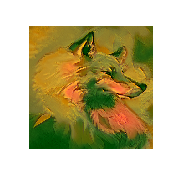

In [28]:
dl.show_batch()

Now it's as simple as passing in our `DataLoader` into `learn.get_preds`

In [0]:
preds, _= learn.get_preds(dl=dl)

In [0]:
preds.shape

torch.Size([3, 3, 688, 620])

In [0]:
for i, im in enumerate(preds):
  print(i)

0
1
2


But we are not done! We also want to save our images away now. Let's borrow from `torchvision.utils`

In [0]:
#export
from torchvision.utils import save_image

We can write a quick `save_im` function to save all our outputed tensors to images

In [0]:
#export
def save_im(imgs:Tensor, path):
  "Save a n*c*w*h `Tensor` into seperate images"
  [save_image(im, f'{path}/{i}.png') for i, im in enumerate(imgs)]

Now let's put it all together

In [0]:
#export
def inference(pkl_name, fnames:list, path:Path, bs:int=1):
  "Grab inference on a model, filenames, and a path to save it to"
  path = path/'results'
  path.mkdir(parents=True, exist_ok=True)
  dl = get_dl(fnames, bs)
  learn = get_learner(pkl_name)
  preds, _ = learn.get_preds(dl=dl)
  save_im(preds, path)

And try it out!

In [0]:
inference('myModel', fnames, path=Path(''))

Lastly let's make a `.py` file again to run it off of

In [0]:
#hide
from nbdev.imports import *
from nbdev.export import reset_nbdev_module, notebook2script

create_config('myLib', user='muellerzr', path='.', cfg_name='settings.ini')
cfg = Config(cfg_name='settings.ini')

In [0]:
#hide
reset_nbdev_module()

In [0]:
#hide
from nbdev.export import notebook2script
notebook2script('05_Inference_Server.ipynb')

Converted 05_Inference_Server.ipynb.


And we're done!